In [2]:
import random

import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from IPython import display
from torchvision import datasets, transforms

# Tutorial 2a: Convolutional Neural Network (CNN)

The code below may be helpful in visualizing PyTorch tensors as images.

In [3]:
%matplotlib inline


def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.grid(False)
    plt.gca().axis("off")


def display_thumb(img):
    display.display(transforms.Resize(128)(img))

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Load MNIST and define train/test functions as before. Please make sure you read the code carefully and understand what it is doing.

In [5]:
# Load the training and test dataset.
mnist_train = datasets.MNIST(
    "/tmp/mnist", train=True, download=True, transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "/tmp/mnist", train=False, download=True, transform=transforms.ToTensor()
)

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size, shuffle=False
)

100.0%
100.0%
100.0%
100.0%


In [6]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""

    # Make sure model is in training mode.
    model.train()

    # Move model to the device (CPU or GPU).
    model.to(device)

    # Exponential moving average of the loss.
    ema_loss = None

    # Loop over epochs.
    for epoch in range(num_epochs):

        # Loop over data.
        for batch_idx, (data, target) in enumerate(data_loader):

            # Forward pass.
            output = model(data.to(device))
            loss = criterion(output.to(device), target.to(device))

            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01

        # Print out progress the end of epoch.
        print(
            "Train Epoch: {} \tLoss: {:.6f}".format(epoch, ema_loss),
        )


def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for data, target in data_loader:

            # Forward pass.
            output = model(data.to(device))

            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)

            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100.0 * correct / len(data_loader.dataset)
    print(f"Accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)")
    return percent

In the last tutorial, you implemented a naive convolution. In this section you will implement your own version of forward pass of nn.Conv2d without using any of PyTorch's (or numpy's) pre-defined convolutional functions.

In [7]:
import torch
import torch.nn.functional as F

def conv_forward_naive(x, w, b, conv_param):
    """
    A naive Python implementation of a convolutional layer.
    Inputs:
    - x: Input data, torch.Tensor of shape (N, C, H, W)
    - w: Filter weights, torch.Tensor of shape (F, C, HH, WW)
    - b: Biases, torch.Tensor of shape (F,)
    - conv_param: dict with keys:
        'stride': int, spacing between receptive fields
        'pad':    int, number of zeros to pad each side
    Returns:
    - out: Output data, torch.Tensor of shape (N, F, H', W')
    """
    N, C, H, W = x.shape
    F_filters, _, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']

    # Compute output dimensions
    H_out = (H + 2*pad - HH) // stride + 1
    W_out = (W + 2*pad - WW) // stride + 1

    # Zero-pad input symmetrically on H and W axes
    # F.pad takes (pad_left, pad_right, pad_top, pad_bottom)
    x_pad = F.pad(x, (pad, pad, pad, pad))  # :contentReference[oaicite:0]{index=0}

    # Initialize output tensor
    out = torch.zeros((N, F_filters, H_out, W_out), dtype=x.dtype, device=x.device)

    # Iterate over each image in batch, each filter, and each spatial position
    for n in range(N):
        for f in range(F_filters):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    h_end   = h_start + HH
                    w_start = j * stride
                    w_end   = w_start + WW

                    # Elementwise product and sum, then add bias
                    window = x_pad[n, :, h_start:h_end, w_start:w_end]
                    out[n, f, i, j] = torch.sum(window * w[f]) + b[f]
    return out

You can test your implementation by running the following testing code:

In [8]:
# Make convolution module.
w_shape = (3, 3, 4, 4)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(torch.tensor(w_shape))).reshape(w_shape)
b = torch.linspace(-0.1, 0.2, steps=3)

# Compute output of module and compare against reference values.
x_shape = (2, 3, 4, 4)
x = torch.linspace(-0.1, 0.5, steps=torch.prod(torch.tensor(x_shape))).reshape(x_shape)
out = conv_forward_naive(x, w, b, {"stride": 2, "pad": 1})

correct_out = torch.tensor(
    [
        [
            [[-0.08759809, -0.10987781], [-0.18387192, -0.2109216]],
            [[0.21027089, 0.21661097], [0.22847626, 0.23004637]],
            [[0.50813986, 0.54309974], [0.64082444, 0.67101435]],
        ],
        [
            [[-0.98053589, -1.03143541], [-1.19128892, -1.24695841]],
            [[0.69108355, 0.66880383], [0.59480972, 0.56776003]],
            [[2.36270298, 2.36904306], [2.38090835, 2.38247847]],
        ],
    ]
)

# Compare your output to ours; difference should be around e-8
print("Testing conv_forward_naive")
rel_error = ((out - correct_out) / (out + correct_out + 1e-6)).mean()
print("difference: ", rel_error)
if abs(rel_error) < 1e-6:
    print("Nice work! Your implementation of a convolution layer works correctly.")
else:
    print(
        "Something is wrong. The output was expected to be {} but it was {}".format(
            correct_out, out
        )
    )

Testing conv_forward_naive
difference:  tensor(4.1913e-08)
Nice work! Your implementation of a convolution layer works correctly.



We will now replace the logistic regressor from the last tutorial by a small convolutional network with two convolutional layers and a linear layer, and ReLU activations in between the layers. Implement the model and use the same functions as before to train and test the convolutional network.

In [9]:
class ConvolutionalNetwork(nn.Module):
    """Simple convolutional network."""

    def __init__(self, image_side_size, num_classes, in_channels=1):
        super().__init__()
        # Convolutional block: output channels = 16, kernel 3×3, padding=1, stride=1
        # followed by ReLU and 2×2 max pooling.
        self.conv_network = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # After pooling, spatial dims halve: from image_side_size → image_side_size/2
        flattened_size = 16 * (image_side_size // 2) * (image_side_size // 2)
        self.linear = nn.Linear(flattened_size, num_classes)

    def forward(self, x):
        x = self.conv_network(x)
        x = x.view(x.size(0), -1)
        return self.linear(x)


# Create and train convolutional network.
# The accuracy should be around 96%.
conv_model = ConvolutionalNetwork(28, 10)
###########################################################################
# TODO: Create criterion and optimize here.                               #
###########################################################################
# Classification loss for C-way logits
criterion = nn.CrossEntropyLoss()  # :contentReference[oaicite:4]{index=4}

# Stochastic gradient descent with learning rate 0.01 and momentum 0.9
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.01, momentum=0.9)  # :contentReference[oaicite:5]{index=5}


train(conv_model, criterion, train_loader, optimizer, num_epochs=5)
test(conv_model, test_loader)

Train Epoch: 0 	Loss: 0.200040
Train Epoch: 1 	Loss: 0.116278
Train Epoch: 2 	Loss: 0.091611
Train Epoch: 3 	Loss: 0.070258
Train Epoch: 4 	Loss: 0.066025
Accuracy: 9800 / 10000 (98%)


98.0

Inspect the filters in the first layer of the trained convolutional network. What do they look like? Why?

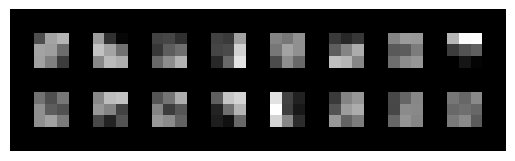

In [10]:
first_conv = list(conv_model.conv_network.children())[0]
show(
    torchvision.utils.make_grid(
        first_conv.weight,
        normalize=True,
        nrow=8,
    )
)